In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf 
import sklearn as sk 
import os 
import cv2
import albumentations as A
from PIL import Image 
from tensorflow import keras 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
training_path = "/kaggle/input/sp-society-camera-model-identification/train/train/"
testing_path = "/kaggle/input/sp-society-camera-model-identification/test/test/"
_,training_classes,_=next(os.walk(training_path))
#print(training_classes)


In [3]:
batch_size = 32
epochs = 1
learning_rate = 1e-3

In [4]:
_,_,testing_files = next(os.walk(testing_path))
#testing_files

In [5]:
training_paths = [] 
labels = [] 
for i in training_classes:
    _,_,filenames = next(os.walk(training_path+i))
    for j in filenames:
        training_paths.append(training_path+i+'/'+j)
        labels.append(i)

In [6]:
assert len(training_paths)==len(labels)

In [7]:
seed = 33

In [8]:
training_data = pd.DataFrame(training_paths,columns=['Training Image Path'])
classes = pd.DataFrame(labels)
classes = pd.get_dummies(classes) # One Hot Encode the class variables

In [9]:
training_data

,Training Image Path
0,/kaggle/input/sp-society-camera-model-identifi...
1,/kaggle/input/sp-society-camera-model-identifi...
2,/kaggle/input/sp-society-camera-model-identifi...
3,/kaggle/input/sp-society-camera-model-identifi...
4,/kaggle/input/sp-society-camera-model-identifi...
...,...
2745,/kaggle/input/sp-society-camera-model-identifi...
2746,/kaggle/input/sp-society-camera-model-identifi...
2747,/kaggle/input/sp-society-camera-model-identifi...
2748,/kaggle/input/sp-society-camera-model-identifi...


In [10]:
classes.head()

,0_HTC-1-M7,0_LG-Nexus-5x,0_Motorola-Droid-Maxx,0_Motorola-Nexus-6,0_Motorola-X,0_Samsung-Galaxy-Note3,0_Samsung-Galaxy-S4,0_Sony-NEX-7,0_iPhone-4s,0_iPhone-6
0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,1,0,0,0


In [11]:
classes_dict = {'0':'HTC-1-M7',
                '1':'LG-Nexus-5x',
                '2':'Motorola-Droid-Maxx',
                '3':'Motorola-Nexus-6',
                '4':'Motorola-X',
                '5':'Samsung-Galaxy-Note3',
                '6':'Samsung-Galaxy-S4',
                '7':'Sony-NEX-7',
                '8':'iPhone-4s',
                '9':'iPhone-6'}

In [12]:
testing_data = pd.DataFrame(testing_files,columns=['Testing Image Path'])
testing_data

,Testing Image Path
0,img_b551817_manip.tif
1,img_90bf577_unalt.tif
2,img_44c7044_unalt.tif
3,img_6481076_unalt.tif
4,img_6f87d1f_manip.tif
...,...
2635,img_f5c6b8e_unalt.tif
2636,img_a9da818_manip.tif
2637,img_53bbd9f_unalt.tif
2638,img_db8cb11_unalt.tif


Shuffling the dataset before sending it to the Tensorflow Pipeline

In [13]:
def read_img(path):
    return np.array(Image.open(path))

In [14]:
length = 512
training_transforms = A.Compose([A.RandomCrop(height=length,width=length),
                                #A.RandomGamma(gamma_limit=(80,120),p=0.5),
                                A.JpegCompression(quality_lower=70,quality_upper=90,p=0.5),
                                A.GridDistortion(interpolation=cv2.INTER_CUBIC),
                                A.HorizontalFlip(p=0.3),
                                A.VerticalFlip(p=0.5)])
    

                                
testing_augmentation = A.Compose([
                                  A.CenterCrop(height=length,width=length)])

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:967: FutureWarning: This class has been deprecated. Please use ImageCompression
  FutureWarning,


In [15]:
class Dataset(keras.utils.Sequence):
    def __init__(self,x,y,batch_size,augmentations,test):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.augmentations = augmentations 
        self.test = test 
    def __len__(self):
        return int(len(self.x)/self.batch_size)
    def __getitem__(self,index):
        batched_x = self.x.iloc[index*self.batch_size:(index+1)*self.batch_size].to_numpy()
        if( not self.test):
            batched_y = self.y.iloc[index*self.batch_size : (index+1)*self.batch_size,:]
            images = [(self.augmentations(image=read_img(i[0]))['image']) for i in batched_x]
        else:
            images = [(self.augmentations(image=read_img(i))['image']) for i in batched_x]
        return np.array(images)if self.test else (np.array(images),batched_y.values)

In [16]:
dummy_dataset = Dataset(training_data,classes,batch_size=batch_size,augmentations=training_transforms,test=False)

(32, 512, 512, 3)
(32, 10)


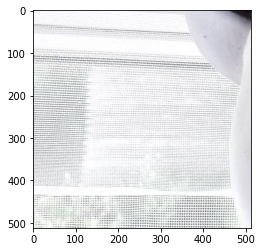

In [17]:
a,b=dummy_dataset.__getitem__(5)
#print(a[0])
print(a.shape)
#print(b)
print(b.shape)
plt.imshow(a[0])

del dummy_dataset

**Creating a baseline model using only an ANN **

In [18]:
def base_model(length,input_size,output_classes):
    ipt_layer = keras.Input(shape=(length,length,3))
    flatten = keras.layers.Flatten()(ipt_layer)
    dense_1 = keras.layers.Dense(input_size//(512*128),activation='relu')(flatten)
    op_layer = keras.layers.Dense(output_classes,activation='softmax')(dense_1)
    optimiser = keras.optimizers.SGD(learning_rate =learning_rate)
    losses = keras.losses.CategoricalCrossentropy()
    metrics = keras.metrics.Accuracy()
    model = keras.Model(inputs = ipt_layer,outputs = op_layer)
    model.compile(optimizer=optimiser,loss=losses,metrics=metrics)
    return model

In [19]:
training_model = base_model(length,length*length*3,10)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

In [20]:
training_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
flatten (Flatten)            (None, 786432)            0         
_________________________________________________________________
dense (Dense)                (None, 12)                9437196   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                130       
Total params: 9,437,326
Trainable params: 9,437,326
Non-trainable params: 0
_________________________________________________________________


In [21]:
xtrain,xval,ytrain,yval = train_test_split(training_data,classes,test_size=0.1,shuffle=True,random_state=seed)

In [22]:
print(len(xtrain),len(xval))
print(len(ytrain),len(yval))

2475 275
2475 275


In [23]:
training_dataset = Dataset(xtrain,ytrain,batch_size=batch_size,augmentations=training_transforms,test=False)
validation_dataset = Dataset(xval,yval,batch_size=batch_size,augmentations=training_transforms,test=False)

print(len(training_dataset))
print(len(validation_dataset))

77
8


In [24]:
model_file = "output/base_model_weights.hd5"

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file, monitor="val_accuracy", save_best_only=True, mode='max')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.9, patience=2, min_lr=1e-6, mode="max", verbose=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, mode="max", verbose=True)

callbacks_list = [checkpoint, reduce_lr, early_stopping]


In [25]:
training_model.fit(training_dataset,validation_data=validation_dataset,epochs=1,batch_size=batch_size,callbacks=callbacks_list,verbose=1)

2021-11-29 07:23:54.693151: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


77/77 [==============================] - 846s 11s/step - loss: 6794.3389 - accuracy: 0.0391 - val_loss: 2.3026 - val_accuracy: 0.0000e+00


2021-11-29 07:38:01.188656: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [26]:
sample_submission = pd.read_csv('/kaggle/input/sp-society-camera-model-identification/sample_submission.csv')
sample_submission.head()

,fname,camera
0,img_0002a04_manip.tif,iPhone-6
1,img_001e31c_unalt.tif,iPhone-6
2,img_00275cf_manip.tif,iPhone-6
3,img_0034113_unalt.tif,iPhone-6
4,img_00344b7_unalt.tif,iPhone-6


In [27]:
x_test = testing_path+sample_submission['fname']
#x_test = x_test.to_numpy()
print(x_test[0])

#training_model.load_model(model_file)
x_test = Dataset(x_test,x_test,test=True,batch_size=1,augmentations=testing_augmentation)

/kaggle/input/sp-society-camera-model-identification/test/test/img_0002a04_manip.tif


In [28]:
def read_and_array(filepath):
    im_array = np.array(Image.open(filepath))
    pil_im = Image.fromarray(im_array)
    new_array = np.array(pil_im)
    return new_array

In [29]:
training_model = tf.keras.models.load_model(model_file)
predicted = training_model.predict(x_test)

In [30]:
print(predicted)

[[0.09994376 0.09997302 0.09992698 ... 0.10001792 0.09993017 0.10004804]
 [0.09994376 0.09997302 0.09992698 ... 0.10001792 0.09993017 0.10004804]
 [0.09994376 0.09997302 0.09992698 ... 0.10001792 0.09993017 0.10004804]
 ...
 [0.09994376 0.09997302 0.09992698 ... 0.10001792 0.09993017 0.10004804]
 [0.09994376 0.09997302 0.09992698 ... 0.10001792 0.09993017 0.10004804]
 [0.09994376 0.09997302 0.09992698 ... 0.10001792 0.09993017 0.10004804]]


In [31]:
test_labels = []
for item in predicted.argmax(axis=1):
    test_labels.append(classes_dict[str(item)])

In [32]:
sample_submission['camera'] = test_labels
sample_submission.head()

,fname,camera
0,img_0002a04_manip.tif,Samsung-Galaxy-Note3
1,img_001e31c_unalt.tif,Samsung-Galaxy-Note3
2,img_00275cf_manip.tif,Samsung-Galaxy-Note3
3,img_0034113_unalt.tif,Samsung-Galaxy-Note3
4,img_00344b7_unalt.tif,Samsung-Galaxy-Note3


In [33]:
sample_submission.to_csv("submission.csv", index=False)